In [1]:
import os
os.chdir("..")

In [28]:
from src.models.unet_model import UNet
import torch
import torch.nn as nn
net = UNet(n_channels=4, n_classes=1, bilinear=True)

In [7]:
test_image = torch.rand((1, 3, 572, 572))
out = net(test_image)

In [8]:
out.shape

torch.Size([1, 1, 572, 572])

In [19]:
enc= list(net.children())[:5]

In [20]:
meeep = nn.Sequential(*enc)

In [21]:
meeep(test_image).shape

torch.Size([1, 512, 35, 35])

In [22]:
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [25]:
torch.min(out)

tensor(-1.3447, grad_fn=<MinBackward1>)

In [26]:
from src.data.particle_dataset import load_dataset
from torch.utils.data import DataLoader
import numpy as np

dataloader = load_dataset(10, dataset_type="unsupervised")

In [27]:
batch_images, batch_labels, image_info = next(iter(dataloader))

In [29]:
out = model(batch_images)

In [30]:
out.shape

torch.Size([10, 1, 200, 2048])

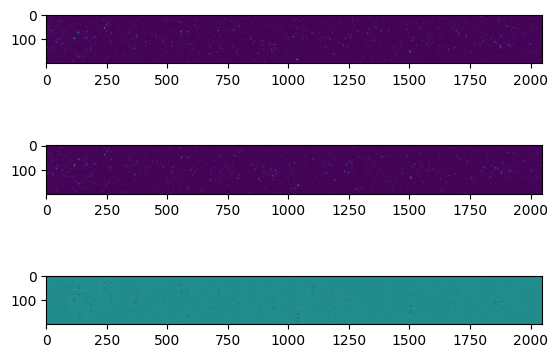

In [32]:
# Plot an image and its mask
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(3, 1)

# Get image from tensor to numpy array
img = batch_images[0,0,:,:].numpy()
mask = batch_labels[0,0,:,:].numpy()

ax[0].imshow(img)
ax[1].imshow(mask)

# Plot the output of the network
ax[2].imshow(out[0,0,:,:].detach().numpy())

plt.show()

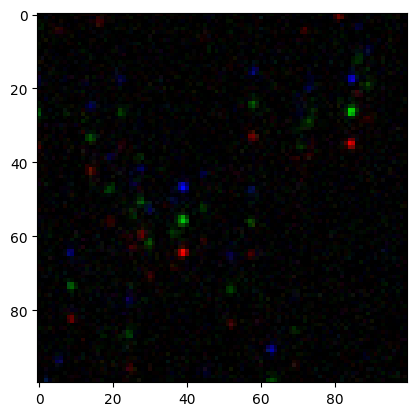

In [34]:
# Stack image channels and mask as RGB

imgR = batch_images[0,1,:,:].numpy()
imgG = batch_labels[0,0,:,:].numpy()
imgB = batch_images[0,2,:,:].numpy()

imgRGB = np.stack((imgR, imgG, imgB), axis=2)

# Do some crop for zooming

imgRGB = imgRGB[100:200, 100:200, :]

plt.imshow(imgRGB)
plt.show()

In [35]:
UNet = lambda: UNet(n_channels=4, n_classes=1, bilinear=True)

In [37]:
from src.models.train_model import load_model
from src.models.unet_model import UNet as UNetmodel
UNet = lambda: UNetmodel(n_channels=4, n_classes=1, bilinear=True)

model = load_model("unsupervised", "UNet")

Model 'unsupervised' loaded with architecture 'UNet'
